## Attempting to implement this algorithm

![Jordan's Quantum Gradient Algorithm](./pics/jordans.png)

#### Only works for approximately linear functions

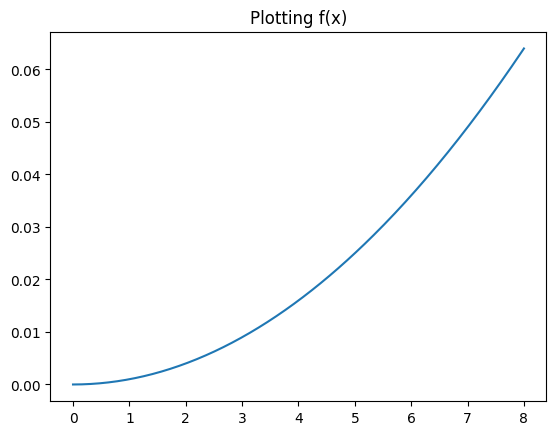

In [3]:
import numpy as np
# def f(x):
#     return (np.sin(x) + np.sin(10 * x / 3) + 2)/560

# def gradient_f(x):
#     return (np.cos(x) + (10/3)*np.cos(10 * x / 3))/560


factor = (1/1000)

def f(x):
    return factor*x**2

def gradient_f(x):
    return factor*x



import matplotlib.pyplot as plt

n_qubits=8
num_points=2**n_qubits

x_t = np.linspace(0,8,num_points,endpoint=True)

y_t = [ f(x_) for x_ in x_t ]


plt.plot(x_t,y_t)
plt.title("Plotting f(x)")
plt.show()

In [4]:
# need to make sure the sum is normalized or at least less than 1
print(f'sum of f(x)\'s = {sum([f(x) for x in x_t])}')
print(f'sum of d/dx of f(x)\'s = {sum([gradient_f(x) for x in x_t])}')
conj_sqrd = lambda x : np.conjugate(x) * x
print(f'sum of |e^(2*pi*2^n*f(x))|^2 = {sum([conj_sqrd(np.exp(2*np.pi*1j*(2**n_qubits)*f(x))) for x in x_t])}')
print(f'len of x_t = {len(x_t)}')

sum of f(x)'s = 5.472041830065361
sum of d/dx of f(x)'s = 1.0240000000000002
sum of |e^(2*pi*2^n*f(x))|^2 = (256+0j)
len of x_t = 256


In [5]:
print(min(y_t),max(y_t))

0.0 0.064


In [6]:
# mapping 0 - 2^n_qubits to actual data points
fixBinary = lambda x : x[2:] if len(x)-2 == n_qubits else '0'*(n_qubits+2-len(x)) + x.split('b')[1]
binary = lambda x: fixBinary(bin(x))
BinaryToDigit = {binary(x): x for x in range(0,2**n_qubits)}
BinaryToData = {binary(i): x_t[i] for i in range(0,2**n_qubits)}

In [7]:
# used for the basis states
def nestedKronecker(args): # use "*args" to access an array of inputs
    import numpy as np
    assert len(args) >= 2
    temp = args[0]
    for arg in args[1:]:
        temp = np.kron(temp, arg)
    return temp

In [8]:
import numpy as np
from qiskit.circuit.gate import Gate
from qiskit import QuantumCircuit,BasicAer,transpile
from qiskit.quantum_info.operators import Operator

### Creating the Oracle $O_f^{\pi 2^n+1}$:

In [9]:
basis = {0: [1,0], 1: [0,1], '0': [1,0], '1': [0,1]}

createBasisVectorFromBinary = lambda binstr : nestedKronecker([basis[x] for x in binstr])

# phase used for phase oracle (normalized version)
getPhase = lambda x : np.exp(2*np.pi*1j*(2**n_qubits)*f(x))

#building the phase oracle manually: sum exponential with outer product of possible states
OracleOperator = np.zeros((2**n_qubits, 2**n_qubits), dtype=np.complex128)
for i in range(2**n_qubits):
    data_point = x_t[i]
    basisVector = createBasisVectorFromBinary(binary(i))
    OracleOperator += getPhase(data_point) * np.outer(basisVector, basisVector)

#### Creating $QFT_{G_n} = U \cdot QFT_n \cdot U$

In [10]:
# create the Quantum Fourier Transform
def QFT():
    qft = QuantumCircuit(n_qubits, n_qubits)
    for target_q in range(n_qubits-1):
        qft.h(target_q)
        for control_q in range(target_q+1,n_qubits,1):
            k=target_q-control_q+1
            phase = 2*np.pi/(2**k)
            qft.cp(phase, control_q, target_q) #R_k gate
        qft.barrier(range(n_qubits))
    qft.h(n_qubits-1)
    qft.barrier(range(n_qubits))
    # apply final swap gates
    for i in range(n_qubits//2):
        qft.swap(i,n_qubits-1-i)
    return qft

# creating the Unitary "U" where U * QFT_n * U = QFT_Gn
getUPhase = lambda x : np.exp(2*np.pi*1j*(-x*(0.5+2**(-n_qubits-1)) + (2**(n_qubits-2)-0.5+2**(-n_qubits-2))/2))

U = np.zeros((2**n_qubits, 2**n_qubits), dtype=np.complex128)
for x in range(2**n_qubits):
    basisVector = createBasisVectorFromBinary(binary(x))
    U += getUPhase(x) * np.outer(basisVector, basisVector)

QFT_n = Operator(QFT())
QFT_n_inv = Operator(np.conjugate(np.transpose(QFT_n.data)))
QFT_Gn = Operator(np.matmul(np.matmul(U,QFT_n.data), U))
QFT_Gn_inv = Operator(np.conjugate(np.transpose(QFT_Gn.data)))

In [11]:
# Double checking the gates are accurately made. Used Nielsen and Chuang book
q = QFT()
q.draw()

┌───┐                                                              ░      »
q_0: ┤ H ├─■───────■───────■───────■────────■────────■────────■─────────░──────»
     └───┘ │P(2π)  │       │       │        │        │        │         ░ ┌───┐»
q_1: ──────■───────┼───────┼───────┼────────┼────────┼────────┼─────────░─┤ H ├»
                   │P(4π)  │       │        │        │        │         ░ └───┘»
q_2: ──────────────■───────┼───────┼────────┼────────┼────────┼─────────░──────»
                           │P(8π)  │        │        │        │         ░      »
q_3: ──────────────────────■───────┼────────┼────────┼────────┼─────────░──────»
                                   │P(16π)  │        │        │         ░      »
q_4: ──────────────────────────────■────────┼────────┼────────┼─────────░──────»
                                            │P(32π)  │        │         ░      »
q_5: ───────────────────────────────────────■────────┼────────┼─────────░──────»
                                                     │P(64π)  │         ░      »
q_6: ────────────────────────────────────────────────■────────┼─────────░──────»
                                                              │P(128π)  ░      »
q_7: ─────────────────────────────────────────────────────────■─────────░──────»
                                                                        ░      »
c: 8/══════════════════════════════════════════════════════════════════════════»
                                                                               »
«                                                         ░              »
«q_0: ────────────────────────────────────────────────────░──────────────»
«                                                         ░              »
«q_1: ─■───────■───────■───────■────────■────────■────────░──────────────»
«      │P(2π)  │       │       │        │        │        ░ ┌───┐        »
«q_2: ─■───────┼───────┼───────┼────────┼────────┼────────░─┤ H ├─■──────»
«              │P(4π)  │       │        │        │        ░ └───┘ │P(2π) »
«q_3: ─────────■───────┼───────┼────────┼────────┼────────░───────■──────»
«                      │P(8π)  │        │        │        ░              »
«q_4: ─────────────────■───────┼────────┼────────┼────────░──────────────»
«                              │P(16π)  │        │        ░              »
«q_5: ─────────────────────────■────────┼────────┼────────░──────────────»
«                                       │P(32π)  │        ░              »
«q_6: ──────────────────────────────────■────────┼────────░──────────────»
«                                                │P(64π)  ░              »
«q_7: ───────────────────────────────────────────■────────░──────────────»
«                                                         ░              »
«c: 8/═══════════════════════════════════════════════════════════════════»
«                                                                        »
«                                        ░                              »
«q_0: ───────────────────────────────────░──────────────────────────────»
«                                        ░                              »
«q_1: ───────────────────────────────────░──────────────────────────────»
«                                        ░                              »
«q_2: ─■───────■───────■────────■────────░──────────────────────────────»
«      │       │       │        │        ░ ┌───┐                        »
«q_3: ─┼───────┼───────┼────────┼────────░─┤ H ├─■───────■───────■──────»
«      │P(4π)  │       │        │        ░ └───┘ │P(2π)  │       │      »
«q_4: ─■───────┼───────┼────────┼────────░───────■───────┼───────┼──────»
«              │P(8π)  │        │        ░               │P(4π)  │      »
«q_5: ─────────■───────┼────────┼────────░───────────────■───────┼──────»
«                      │P(16π)  │        ░                       │P(8π) »
«q_6: ─────────────────■────────┼────────░───────────────────────■──────»
«    

#### Qiskit does string output reversal. Proved by the next line of code

In [12]:
# this is to make sure things are run in the right order !!!
n_shots11 = 10
backend = BasicAer.get_backend('qasm_simulator')

print('We are expecting \'10\' bitstring to be measured')
qc1 = QuantumCircuit(2,2)
qc1.x(0)
qc1.barrier(range(2))
qc1.measure([0,1],[0,1])

job1 = backend.run(transpile(qc1, backend, optimization_level=2), shots=n_shots11)

res1 = job1.result().get_counts() # dictionary of outcomes
print('results = {bistring: counts} = ',res1)
print('therefore shows we need to do qc.measure(qubits,reversed(qubits))')
qc1.draw()

We are expecting '10' bitstring to be measured
results = {bistring: counts} =  {'01': 10}
therefore shows we need to do qc.measure(qubits,reversed(qubits))


┌───┐ ░ ┌─┐   
q_0: ┤ X ├─░─┤M├───
     └───┘ ░ └╥┘┌─┐
q_1: ──────░──╫─┤M├
           ░  ║ └╥┘
c: 2/═════════╩══╩═
              0  1

### Now build the entire Jordan's Quantum Algorithm

In [13]:
# build the entire circuit
qc = QuantumCircuit(n_qubits,n_qubits)
qc.h([i for i in range(n_qubits)])
oracle = Operator(OracleOperator)
qc.unitary(oracle, range(n_qubits),label="Oracle_f")
qc.unitary(QFT_Gn_inv, range(n_qubits),label="QFT_Gn^(-1)")
qc.measure(range(n_qubits), range(n_qubits-1,-1,-1)) # reversing measurement since qiskit does reverse output, which is proved on the next line
qc.draw()

┌───┐┌───────────┐┌──────────────┐┌─┐                     
q_0: ┤ H ├┤0          ├┤0             ├┤M├─────────────────────
     ├───┤│           ││              │└╥┘┌─┐                  
q_1: ┤ H ├┤1          ├┤1             ├─╫─┤M├──────────────────
     ├───┤│           ││              │ ║ └╥┘┌─┐               
q_2: ┤ H ├┤2          ├┤2             ├─╫──╫─┤M├───────────────
     ├───┤│           ││              │ ║  ║ └╥┘┌─┐            
q_3: ┤ H ├┤3          ├┤3             ├─╫──╫──╫─┤M├────────────
     ├───┤│  Oracle_f ││  QFT_Gn^(-1) │ ║  ║  ║ └╥┘┌─┐         
q_4: ┤ H ├┤4          ├┤4             ├─╫──╫──╫──╫─┤M├─────────
     ├───┤│           ││              │ ║  ║  ║  ║ └╥┘┌─┐      
q_5: ┤ H ├┤5          ├┤5             ├─╫──╫──╫──╫──╫─┤M├──────
     ├───┤│           ││              │ ║  ║  ║  ║  ║ └╥┘┌─┐   
q_6: ┤ H ├┤6          ├┤6             ├─╫──╫──╫──╫──╫──╫─┤M├───
     ├───┤│           ││              │ ║  ║  ║  ║  ║  ║ └╥┘┌─┐
q_7: ┤ H ├┤7          ├┤7             ├─╫──╫──╫──╫──╫──╫──╫─┤M├
     └───┘└───────────┘└──────────────┘ ║  ║  ║  ║  ║  ║  ║ └╥┘
c: 8/═══════════════════════════════════╩══╩══╩══╩══╩══╩══╩══╩═
                                        7  6  5  4  3  2  1  0

In [14]:
n_shots = 10000
backend = BasicAer.get_backend('qasm_simulator')

job = backend.run(transpile(qc, backend), shots=n_shots)


res = job.result().get_counts() # dictionary of outcomes

In [15]:
print(len(res))

203


In [16]:
from bitstring import BitArray
from random import choice
correctedNum = lambda x : x if x>=0 else (2**n_qubits + x)
rand_bin_x = choice(list(res.keys()))
data_point = BinaryToData[rand_bin_x]
print(rand_bin_x, ' => ', correctedNum(BitArray(bin=rand_bin_x).int))
print(f'expected: f\'(x) = d\dx * f(x) = {gradient_f(data_point)}')
result1 = 'Does Not Exist' if rand_bin_x not in res else res[rand_bin_x]/n_shots
print(f'experimental: res[{rand_bin_x}] = {result1}')

11111011  =>  251
expected: f'(x) = d\dx * f(x) = 0.007874509803921568
experimental: res[11111011] = 0.0015


In [17]:
# cleaning up results 
new_res = [[b_x, correctedNum(BitArray(bin=b_x).int), res[b_x]] for b_x in res.keys()]
new_res.sort(key=lambda x : x[0])
new_res = np.array([x for x in new_res if x[2]>=10])
new_res = np.array([[int(x1),int(x2)] for x1,x2 in new_res[:,1:]])
print(f'new_res format => [[decimal_num, counts]...]')

temp = list([int(x) for x in new_res[:,1].copy().flatten()])
ind = temp.index(max(temp))
max_count_val = new_res[ind]

new_res format => [[decimal_num, counts]...]


#### All the outputs of circuit measurements visualized

In [29]:
def barplot(results):
    from matplotlib import pyplot as plt

    # Creating histogram 
    fig, ax = plt.subplots(1, 1, figsize=(15,15))
    print(type(results[0][0]), type(results[0][1]))
    ax.bar(results[:,0], height=results[:,1], width=3, align='center')

    # Set title 
    ax.set_title(f"Histogram of measured basis states ($x_b$) from {n_shots} shots") 

    # adding labels 
    xlabel = f'\'b\' from basis state $x_b$\nwhere b = integer (0 to 2^n-1) --> $x_b$ = binary representation of \'b\''
    ax.set_xlabel(xlabel)
    ax.set_ylabel('Measured observable counts')


    # Make some labels. 
    rects = ax.patches 
    labels = results[:,1]

    for rect, label in zip(rects, labels): 
        height = rect.get_height() 
        ax.text(rect.get_x() + rect.get_width() / 2, height+0.5, label, 
                ha='center', va='bottom', rotation='vertical')
    plt.xticks(results[:,0], rotation='vertical')
    # Show plot
    plt.show()

<class 'numpy.int64'> <class 'numpy.int64'>


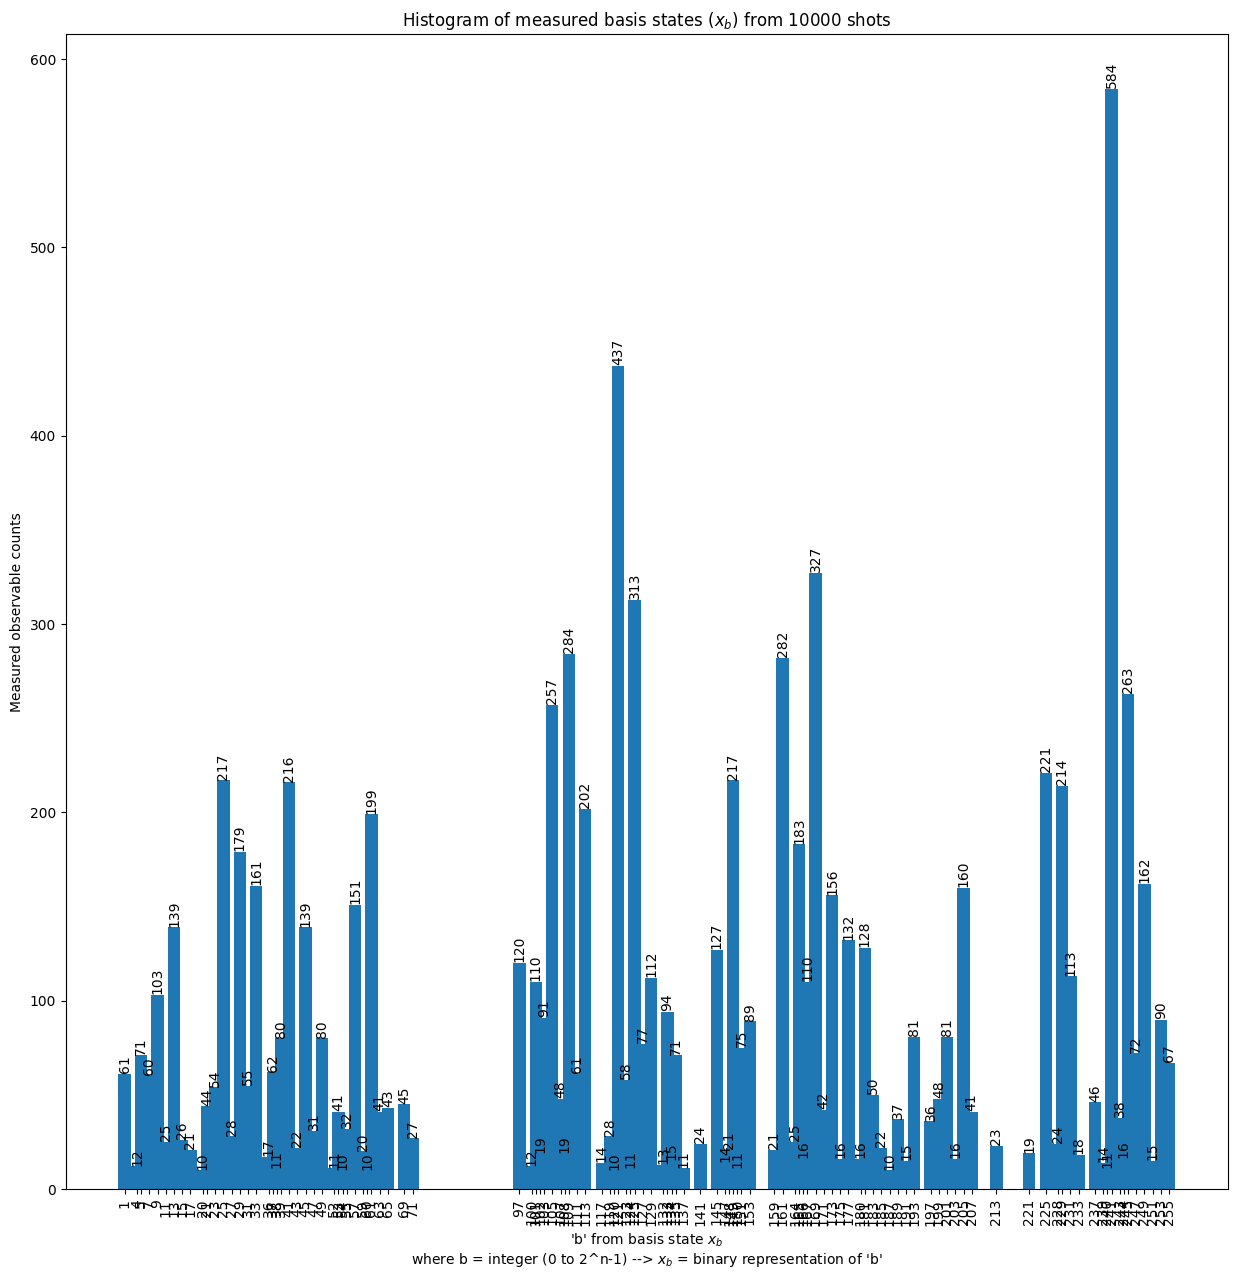

xdata min = 0.0, xdata max = 8.0, len(xdata) = 2^8 = 256 = len(set{x_b's})


In [30]:
barplot(new_res)
print(f'xdata min = {x_t[0]}, xdata max = {x_t[-1]}, len(xdata) = 2^{n_qubits} = {len(x_t)} = len(set{{x_b\'s}})')

# ---------------------------------------------
# ---------------------------------------------
## Not sure what the outputs meant so implementing $QFT_n$ instead of $QFT_{G_n}$

In [19]:
# build an alternative
qca = QuantumCircuit(n_qubits,n_qubits)
qca.h([i for i in range(n_qubits)])
qca.unitary(oracle, range(n_qubits),label="Oracle_f")
qca.unitary(QFT_n_inv, range(n_qubits),label="QFT_n^(-1)")
qca.measure(range(n_qubits), range(n_qubits-1,-1,-1)) # reversing measurement since qiskit does reverse output, which is proved on the next line
qca.draw()

┌───┐┌───────────┐┌─────────────┐┌─┐                     
q_0: ┤ H ├┤0          ├┤0            ├┤M├─────────────────────
     ├───┤│           ││             │└╥┘┌─┐                  
q_1: ┤ H ├┤1          ├┤1            ├─╫─┤M├──────────────────
     ├───┤│           ││             │ ║ └╥┘┌─┐               
q_2: ┤ H ├┤2          ├┤2            ├─╫──╫─┤M├───────────────
     ├───┤│           ││             │ ║  ║ └╥┘┌─┐            
q_3: ┤ H ├┤3          ├┤3            ├─╫──╫──╫─┤M├────────────
     ├───┤│  Oracle_f ││  QFT_n^(-1) │ ║  ║  ║ └╥┘┌─┐         
q_4: ┤ H ├┤4          ├┤4            ├─╫──╫──╫──╫─┤M├─────────
     ├───┤│           ││             │ ║  ║  ║  ║ └╥┘┌─┐      
q_5: ┤ H ├┤5          ├┤5            ├─╫──╫──╫──╫──╫─┤M├──────
     ├───┤│           ││             │ ║  ║  ║  ║  ║ └╥┘┌─┐   
q_6: ┤ H ├┤6          ├┤6            ├─╫──╫──╫──╫──╫──╫─┤M├───
     ├───┤│           ││             │ ║  ║  ║  ║  ║  ║ └╥┘┌─┐
q_7: ┤ H ├┤7          ├┤7            ├─╫──╫──╫──╫──╫──╫──╫─┤M├
     └───┘└───────────┘└─────────────┘ ║  ║  ║  ║  ║  ║  ║ └╥┘
c: 8/══════════════════════════════════╩══╩══╩══╩══╩══╩══╩══╩═
                                       7  6  5  4  3  2  1  0

In [20]:
joba = backend.run(transpile(qca, backend), shots=n_shots)
resa = joba.result().get_counts()
print(len(resa))

187


In [21]:
from bitstring import BitArray
from random import choice
rand_bin_x = choice(list(resa.keys()))
data_point = BinaryToData[rand_bin_x]
print(rand_bin_x, ' => ', correctedNum(BitArray(bin=rand_bin_x).int))
print(f'expected: f\'(x) = d\dx * f(x) = {gradient_f(data_point)}')
result1 = 'Does Not Exist' if rand_bin_x not in res else res[rand_bin_x]/n_shots
print(f'experimental: res[{rand_bin_x}] = {result1}')

00101111  =>  47
expected: f'(x) = d\dx * f(x) = 0.0014745098039215688
experimental: res[00101111] = 0.0031


In [22]:
# cleaning up results 
new_resa = [[b_x, correctedNum(BitArray(bin=b_x).int), resa[b_x]] for b_x in resa.keys()]
new_resa.sort(key=lambda x : x[0])
new_resa = np.array([x for x in new_resa if x[2]>=10])
new_resa = np.array([[int(x1),int(x2)] for x1,x2 in new_resa[:,1:]])
print(f'new_resa format => [[decimal_num, counts]...]')

tempa = list([int(x) for x in new_resa[:,1].copy().flatten()])
inda = tempa.index(max(tempa))
max_count_val = new_resa[inda]

new_resa format => [[decimal_num, counts]...]


#### Visualizing what that looks like

<class 'numpy.int64'> <class 'numpy.int64'>


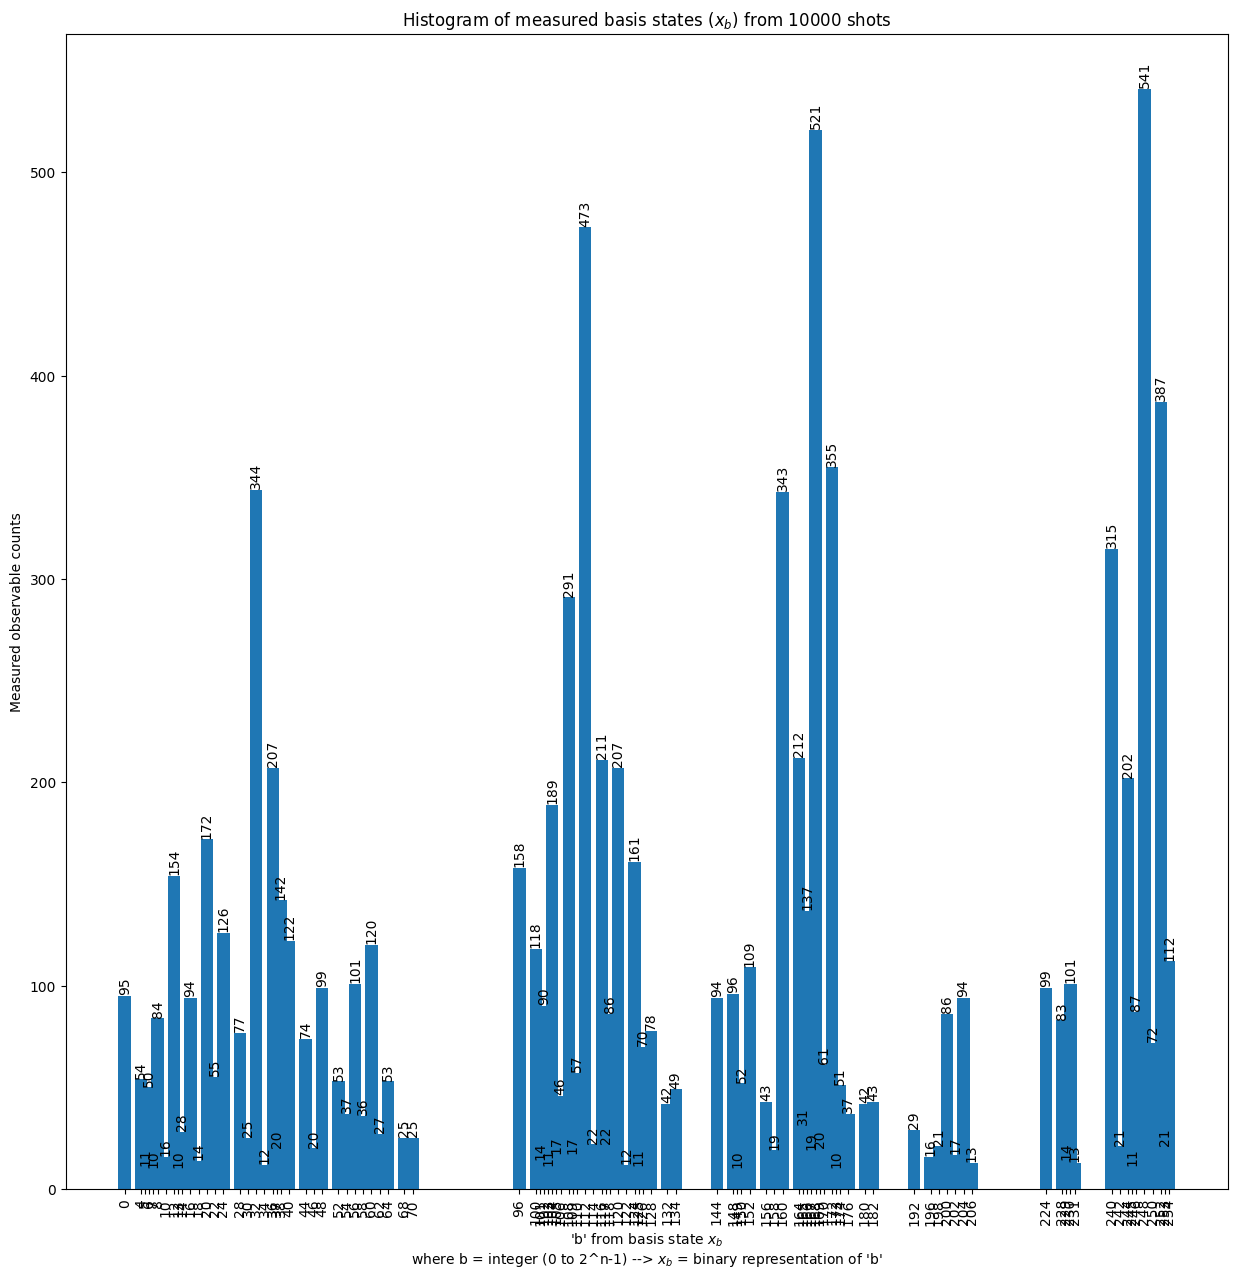

xdata min = 0.0, xdata max = 8.0, len(xdata) = 2^8 = 256 = len(set{x_b's})


In [31]:
barplot(new_resa)
print(f'xdata min = {x_t[0]}, xdata max = {x_t[-1]}, len(xdata) = 2^{n_qubits} = {len(x_t)} = len(set{{x_b\'s}})')